https://huggingface.co/facebook/wav2vec2-base-960h

## 1) 파이프라인

wav2vec 모델 -> 특징추출 -> 임베딩 -> MLP -> healthy/ parkinson

### 1. 라이브러리

In [1]:
import os
import numpy as np
import torch
import soundfile as sf
from tqdm import tqdm
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset, DatasetDict
import torchaudio


c:\Users\qkrgu\anaconda3\envs\wav2vec2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. 데이터 경로 설정

In [2]:
# GPU 사용 가능 여부 확인
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [4]:
DATA_ROOT = "E:/PD_Voice_Wav2Vec2_project/data/vowel_data_preprocessed"  # 학습용 데이터
EXTERNAL_ROOT = "E:/PD_Voice_Wav2Vec2_project/data/italian_voice_pdhc_split"  # 테스트용 데이터

def load_audio_dataset(root):
    files, labels = [], []
    for label_name in ["healthy", "parkinson"]:
        label = 0 if label_name == "healthy" else 1
        folder = os.path.join(root, label_name)
        for f in os.listdir(folder):
            if f.endswith(".wav") or f.endswith(".flac"):
                files.append(os.path.join(folder, f))
                labels.append(label)
    return Dataset.from_dict({"path": files, "label": labels})

train_dataset = load_audio_dataset(DATA_ROOT)
test_dataset = load_audio_dataset(EXTERNAL_ROOT)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['path', 'label'],
        num_rows: 676
    })
    test: Dataset({
        features: ['path', 'label'],
        num_rows: 200
    })
})


### 3. processor 입력으로 변환

In [5]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

def preprocess_function(batch):
    audio_arrays = [sf.read(path)[0] for path in batch["path"]]
    inputs = processor(
        audio_arrays,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True  # attention mask 추가
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    batch["input_values"] = inputs["input_values"]
    batch["attention_mask"] = inputs["attention_mask"]
    return batch


dataset = dataset.map(preprocess_function, batched=True, batch_size=8)


c:\Users\qkrgu\anaconda3\envs\wav2vec2\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\qkrgu\.cache\huggingface\hub\models--facebook--wav2vec2-base-960h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 200/200 [00:11<00:00, 17.62 examples/s]


### 4. 모델 정의

In [6]:
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=2,
    problem_type="single_label_classification",
)



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5. metrics 및 trainer 설정

In [11]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric.compute(predictions=preds, references=labels)
    return acc

training_args = TrainingArguments(
    output_dir="./wav2vec2-finetuned-pd-preprocess-weightdecay-again",
    eval_strategy="epoch",        # (기존 eval_strategy -> evaluation_strategy)
    save_strategy="epoch",
    logging_strategy="steps",            # 로그를 일정 step마다 출력
    logging_steps=10,                    # 10 step마다 출력 (원하는 주기로 조절)
    learning_rate=1e-5,
    weight_decay=0.01,   # L2 정규화 강도 (보통 0.01 ~ 0.001)
    # warmup_ratio=0.1,    # (선택) 학습 초반 안정화용
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    fp16=True,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none",                    # wandb/tensorboard 사용 안 하면 none으로
)



### 6. 파인튜닝 실행

In [12]:
import torch

print(torch.cuda.is_available())  # True면 GPU 사용 가능
print(torch.cuda.get_device_name(0))  # GPU 이름 출력


True
NVIDIA GeForce RTX 4070 SUPER


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(device)         # cuda
print(next(model.parameters()).device)  # 모델 파라미터가 올라간 디바이스 확인


cuda
cuda:0


In [14]:
# #from transformers import DataCollatorForAudioClassification

# #data_collator = DataCollatorForAudioClassification(processor=processor)

import torch

def audio_data_collator(features):
    # 입력값 리스트
    input_values = [torch.tensor(f["input_values"]) for f in features]
    attention_mask = [torch.tensor(f["attention_mask"]) for f in features]
    labels = torch.tensor([f["label"] for f in features], dtype=torch.long)

    # padding (길이가 다른 오디오를 동일 길이로 맞춤)
    input_values = torch.nn.utils.rnn.pad_sequence(
        input_values, batch_first=True, padding_value=0.0
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        attention_mask, batch_first=True, padding_value=0
    )

    return {
        "input_values": input_values,
        "attention_mask": attention_mask,
        "labels": labels,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=processor,   # tokenizer 대신 processor로 교체
    data_collator=audio_data_collator,
    compute_metrics=compute_metrics,
)


trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.633500,0.654987,0.590000


KeyboardInterrupt: 

## 2) 파인튜닝 후 데이터 시각화

### 0. 저장된 fine-tuned 모델 로드

- 런타임 종료 시 사용

In [15]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

MODEL_PATH = "E:/PD_Voice_Wav2Vec2_project/model/wav2vec2/wav2vec2-finetuned-pd-preprocess-weightdecay/checkpoint-1690"  # Trainer가 저장한 디렉토리
processor = Wav2Vec2Processor.from_pretrained(MODEL_PATH)
model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL_PATH)
model.eval()


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


### 1. 임베딩 추출 함수 정의

In [ ]:
def extract_embeddings(file_list, labels):
    embeddings, y = [], []

    model.to(DEVICE)  # 모델이 확실히 GPU로 이동하도록 추가

    for path, label in tqdm(zip(file_list, labels), total=len(file_list)):
        audio, sr = sf.read(path)
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)

        # 입력값도 GPU로 이동
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden = outputs.hidden_states[-1]  # 마지막 레이어
            pooled = torch.mean(hidden, dim=1).squeeze().cpu().numpy()  # (feature_dim,)
        
        embeddings.append(pooled)
        y.append(label)
    
    return np.array(embeddings), np.array(y)



### 2. 임베딩 계산

In [19]:
X_train, y_train = extract_embeddings(train_dataset["path"], train_dataset["label"])
X_test, y_test = extract_embeddings(test_dataset["path"], test_dataset["label"])

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

print("임베딩 shape:", X.shape)  # (N, 768 등)

100%|██████████| 200/200 [09:01<00:00,  2.71s/it]

임베딩 shape: (876, 768)


### 3. Umap 시각화

c:\Users\qkrgu\anaconda3\envs\wav2vec2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


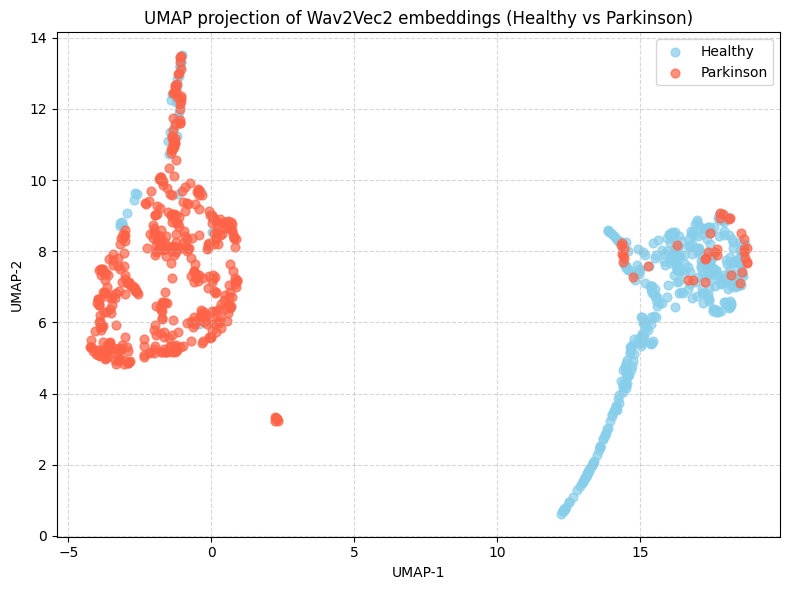

In [20]:
import umap
reducer = umap.UMAP(
    n_neighbors=15,     # 지역 구조 보존 정도
    min_dist=0.1,       # 군집 간 간격
    n_components=2,     # 2D 시각화
    metric="cosine",    # 코사인 거리로 유사도 계산
    random_state=42
)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(
    X_umap[y == 0, 0], X_umap[y == 0, 1],
    c='skyblue', label='Healthy', alpha=0.7, s=40
)
plt.scatter(
    X_umap[y == 1, 0], X_umap[y == 1, 1],
    c='tomato', label='Parkinson', alpha=0.7, s=40
)
plt.legend()
plt.title("UMAP projection of Wav2Vec2 embeddings (Healthy vs Parkinson)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()